Projet Algèbre Linéaire pour la Data Science
================================================

Ce notebook à pour but d'expliquer la méthode de [SVD randomisée](https://research.fb.com/blog/2014/09/fast-randomized-svd/). <br>

Sommaire :
--------------------
1. Calcul d'une SVD classique et mesure de temps
2. Explication et implémentation de la version randomisée
3. Mesures pour la version randomisée en changeant les paramètres
   1. Calcul de performance
   2. Estimation de l'erreur
4. Calculs de statistiques sur l'erreur moyenne
   
   

# 1. Librairies python et récupération de l'image

Shape :  (3906, 6946)


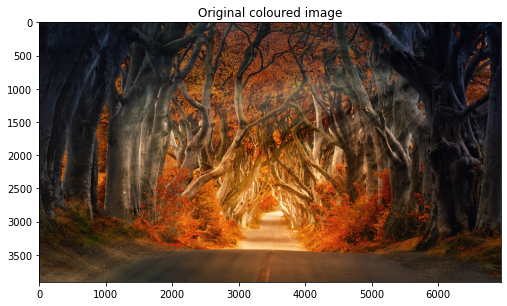

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from time import perf_counter
from utils import *
from svd_func import *

np.set_printoptions(threshold=100)

img = getColouredImage('./resources/small_6946x3906.jpg') #SVD : about a minute
# img = getColouredImage('./resources/big_12kx8k.jpg')
# img = getColouredImage('./resources/huge_12kx14k.jpg')

img = toGrayScale(img)
print("Shape : ",np.array(img).shape)

# 2. SVD classique

In [3]:
A = np.array(img).transpose() #we transpose because the pic is horizontal
m, n = A.shape
size = m*n

print("Matrix shape :", A.shape)
print("Total number of elements :", size)

start = perf_counter()  
A_reconstructed = svd_regular(A)
end = perf_counter()

exact_error, rms_magnitude = compute_error(A, A_reconstructed)
print_result(exact_error, rms_magnitude, end-start, "Regular SVD")

Matrix shape : (6946, 3906)
Total number of elements : 27131076

####################################################################
Regular SVD
>>> Duration : 36.06150 sec.
>>> Rooted mean squared Error (RMSE) : 10e-16
>>> Rooted sum squared Erros (RSSE)  : 1.108198801741345e-09
####################################################################


On constate que cette méthode est efficace car l'erreur est très petite (amplitude d'environ `10e-16`). Cependant, elle est très longue à réaliser.
# 3. Méthodes de SVD randomisées
Dans cette partie nous allons projeter notre matrice $A$ dans un sous espace vectoriel plus petit afin de réaliser une SVD efficace sur ce sous espace restreint. <br>

## Algèbre linéaire randomisée
Nous allons dans un premier temps nous intéresser aux méthodes d'algèbre linéaire randomisées. <br>
Notamment la manière dont nous allons choisir notre "petit" sous espace dans lequel nous allons projeter $A$.
<br>
L'idée principale est donc de générer un sous-espace de $A$ qui approxime l'espace complet de $A$. <br>
Pour cela, nous allons choisir une matrice $\Omega$, générée de manière *aléatoire* et allons projeter A dans cet espace. <br>
La question naturelle qui se pose est : ***comment choisir efficacement notre $\Omega$ ?***

### Matrice à valeurs Gausiennes, Uniformes, ou "colonnes"
Nous allons observer le comportement de $\Omega$ en fonction de la méthode utilisée pour sa génération aléatoire.
Ensuite, nous étudierons ces différents $\Omega$ notamment à l'aide de SVD. <br>

Prenons 3 matrices : <br>
$$
\Omega_{1} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{N}(0,1) \\ 
\ \\
\Omega_{2} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{U}([0,1]) \\
\ \\
\Omega_{3} \in \mathbb{R}^{m \times n} : \forall i \in \llbracket0~;~n\rrbracket,~ \exists!~j \sim \mathcal{U}(\llbracket0,m\rrbracket) : \Omega_{i,j} = 1 \\
et\ \Omega_{i,k}=0 \ \ \forall~k \ne j
$$
- La première est une matrice à valeurs Gausiennes.<br>
- La seconde est une matrice à valeurs Uniformes.<br>
- La troisième est une matrice avec une unique valeur à 1 pour chaque colonne.<br>


Nous allons jouer sur la valeur de $m$ et observer comment convergent les matrices.

In [13]:
m = 10000
n = 10

Omega1=np.random.normal(0, 1, (m, n))

Omega2=np.random.uniform(0, 1, (m, n))

Omega3=np.zeros((m, n))
for c in Omega3.T :
    random_int = randint(0, m)
    c[random_int] = 1
    
U1, S1, Vt1 = np.linalg.svd(normalize(Omega1.T), full_matrices=False)
U2, S2, Vt2 = np.linalg.svd(normalize(Omega2.T), full_matrices=False)
U3, S3, Vt3 = np.linalg.svd(normalize(Omega3), full_matrices=False)

print("Sigma O1 :\n", np.diag(S1).round(2))
print("Sigma O2 :\n", np.diag(S2).round(2))
print("Sigma O3 :\n", np.diag(S3).round(2))
# print("O1 :\n", Omega1.round(2))
# print("O2 :\n", Omega2.round(2))
# print("O3 :\n", Omega3.round(2))

Sigma O1 :
 [[1.03 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.98]]
Sigma O2 :
 [[2.78 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.51 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.51 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.51 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.51 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.  ]
 [0.   0.   0.   0.  

Ces matrices $\Omega_{i}$ seront utilisées pour projeter A et obtenir un sous espace réduit sur lequel nous pourront réaliser des factorisations dans la suite du notebook (en commençant par une décomposition QR).